In [ ]:
import tensorflow as tf
import logging
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
import numpy as np
import json
from IPython.display import clear_output

%config Completer.use_jedi = False
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [ ]:
# %%capture
from tqdm.notebook import tqdm
# tqdm().pandas()

In [ ]:
def set_memory_growth(gpu_id):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                logging.info("Detect {} Physical GPUs, {} Logical GPUs.".format(len(gpus), len(logical_gpus)))
        except RuntimeError as e:
            logging.info(e)

In [ ]:
set_memory_growth(1)

In [ ]:
path_det = '/home/addfor/projects/smart_tray/20_5006v02-intp-detection-foodv01/det2_model/saved_model'
det = tf.saved_model.load(path_det)

In [ ]:
DATASETS_LIST = [
    "run_3_revisited_5may2021",
    "Sodexo_revisited_8jun",
    "Test_Empoli_01_06_2021",
    "Test_Empoli_08_06_2021",
    "Test_Empoli_09_06_2021",
    "Test_Empoli_26_05_2021",
    "Test_Empoli_27_05_2021",
    "Test_Empoli_28_05_2021",
    "Test_Empoli_29_04_2021",
    "Test_Empoli_30_04_2021",
    "Test_Empoli_31_05_2021",
    "Test_Empoli_from_10_06_2021_to_30_06_2021",
    "UNIMIB_revisited_7giu2021"
]
DATASETS_LIST = [Path(ds) for ds in DATASETS_LIST]

BASE_PATH = Path('/mnt/data/smarttray/dataset_05jul2021_av3b')

ths = [0.15, 0.2, 0.25, 0.3, 0.375, 0.35, 0.425, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

with open(BASE_PATH/'COCO_format_results(Adrian)/det2/det2val.json') as f:
    d = json.load(f)
    imgs_metadata = d["images"]

# Getting and saving the validation predictions as np arrays



In [ ]:
def draw_bbs(img, bbs, color):
    height, width, _ = img.shape
    for ymin, xmin, ymax, xmax in bbs:
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 10)

In [ ]:
# preds = {th:[] for th in ths}

# def get_img_id(img_name, imgs_metadata):
#     for metadata in imgs_metadata:
#         if metadata['file_name'] == img_name:
#             return metadata['id']

# for img_data in tqdm(imgs_metadata):
#     img_path = BASE_PATH/img_data['path_from_base']
#     img_id = img_data['id']

#     img = cv2.imread(str(img_path))
#     h, w, _ = img.shape
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (400,400), cv2.INTER_AREA)

#     out = det(img[None])
#     all_scrs, all_bbs, all_classes = out['detection_scores'].numpy(), out['detection_boxes'].numpy(), out['detection_classes'].numpy()
#     for th in ths:    
#         bbs, classes, scrs = all_bbs[all_scrs > th], all_classes[all_scrs > th], all_scrs[all_scrs > th]         
#         bbs = [[int(x1*w), int(y1*h), int(x2*w), int(y2*h)] for y1, x1, y2, x2 in bbs]

#         for (x1,y1,x2,y2), cls, scr in zip(bbs, classes, scrs):
#             preds[th].append([img_id, x1, y1, x2-x1, y2-y1, scr, int(cls)])
    
    
# #     bbs = [[y1*400/h,x1*400/w,y2*400/h,x2*400/w] for x1, y1, x2, y2 in bbs]
# #     print(bbs, img.shape)
# #     draw_bbs(img, bbs, [0,0,255])
# #     fig, ax = plt.subplots(figsize=(7,6))
# #     ax.imshow(img)
# #     plt.show()
# #     input('Press enter to continue')
# #     clear_output()
    

# for th, p in preds.items():
#     np.save(BASE_PATH/'COCO_format_results(Adrian)'/'det2'/f'dets2_th_{th}', np.array(p))

In [ ]:
def nms(anns, nms_iou_th=0.8):
    anns = sorted(anns, key=lambda x: x['score'])
    i = 0 
    while i < len(anns):
        bb1 = anns[i]['bbox']
        j = i + 1
        while j < len(anns):
            bb2 = anns[j]['bbox']
            if IoU(bb1, bb2) > nms_iou_th: anns.pop(j)
            else: j += 1
        i += 1
    return anns

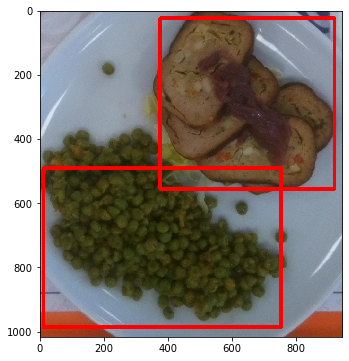

KeyboardInterrupt: Interrupted by user

In [ ]:
cocoGt = COCO(BASE_PATH/'COCO_format_results(Adrian)/det2'/'det2val.json')
dts = np.load(BASE_PATH/'COCO_format_results(Adrian)/det2'/f'dets2_th_{0.6}.npy')
cocoDt = cocoGt.loadRes(dts)
clear_output()

for img_id in range(100):
    img_dict = cocoGt.imgs[img_id]
    img_path = BASE_PATH/cocoGt.imgs[img_id]['path_from_base']
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    Dtbbs = []
    Dtanns = cocoDt.imgToAnns[img_id]
    Dtanns = nms(Dtanns, nms_iou_th=0.4)
    for ann in Dtanns:
        x,y,w,h = ann['bbox']
        Dtbbs.append([y,x,y+h,x+w])
    
    Gtbbs = []
    for ann in cocoGt.imgToAnns[img_id]:
        x,y,w,h = ann['bbox']
        Gtbbs.append([y,x,y+h,x+w])

    draw_bbs(img,Dtbbs,[255,0,0])
    
    fig, ax = plt.subplots(figsize=(7,6))
    ax.imshow(img)
    plt.show()
    
    x = input('press enter')
    if x=='c': raise Exception()
    clear_output()


# Measuring the performance on my own 

In [ ]:
def area(b): return b[2]*b[3]

def IoU(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xminInt = max(x1, x2)
    xmaxInt = min(x1 + w1, x2 + w2)
    yminInt = max(y1, y2)
    ymaxInt = min(y1 + h1, y2 + h2)
    AInt = area((xminInt, yminInt, xmaxInt - xminInt,  ymaxInt - yminInt))
    return AInt/(area(b1) + area(b2) - AInt)

In [ ]:
IoU((0,0,0.5,0.5), (0.25, 0.25, 0.5, 0.5)) == 1/7, IoU((0,0,0.5,0.5), (0, 0, 0.75, 0.75)) == 4/9

(True, True)

In [ ]:
def get_metrics(gt, dt, IoU_th, with_nms=False, nms_th=0.8):
    used_pbbs = []
    dt = nms(dt, nms_th) if with_nms else dt
    for ann in gt:
        bb = ann['bbox']
        for pred_ann in dt:
            pbb = pred_ann['bbox']
            if IoU(bb, pbb) > IoU_th and pred_ann['id'] not in used_pbbs:
                used_pbbs.append(pred_ann['id'])
                break

    TP = len(used_pbbs)
    FP = len(dt) - TP
    FN = len(gt) - TP

    p = TP/(TP + FP) if TP + FP > 0 else 0
    r = TP/(TP + FN)
    return p, r

def get_avg_metrics(cocoGt, cocoDt, IoU_th, with_nms=False, nms_th=0.8):
    ps, rs = [], []
    for img_id in cocoGt.getImgIds():
        gt = cocoGt.imgToAnns[img_id]
        dt = cocoDt.imgToAnns[img_id]
        p, r = get_metrics(gt, dt, IoU_th, with_nms, nms_th)
        ps.append(p); rs.append(r)
    return sum(ps)/len(ps), sum(rs)/len(rs)

In [ ]:
ths = [0.15, 0.2, 0.25, 0.3, 0.35, 0.375, 0.4, 0.425, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
nms_ths = [0.2, 0.4, 0.6, 0.8, 1] 

all_ps, all_rs = [], []
for nms_th in nms_ths:
    ps, rs = [], []
    for th in ths:
        cocoGt = COCO(BASE_PATH/'COCO_format_results(Adrian)/det2'/'det2val.json')
        dts = np.load(BASE_PATH/'COCO_format_results(Adrian)/det2'/f'dets2_th_{th}.npy')
        cocoDt = cocoGt.loadRes(dts)
        p, r = get_avg_metrics(cocoGt, cocoDt, IoU_th=0.75, with_nms=True, nms_th=nms_th)
        ps.append(p); rs.append(r)
        clear_output()
        
    all_ps.append(ps); all_rs.append(rs)

# fig, axs = plt.subplots(ncols=2, figsize=(15,4))
# axs[0].plot(ths, ps); axs[1].plot(ths, rs)

In [ ]:
for nms_th, ps, rs in zip(nms_ths, all_ps, all_rs):
    ps, rs = np.array(ps), np.array(rs)
    f1s = 2*ps*rs/(ps + rs)
#     plt.plot(ths, f1s)
    print(f'{nms_th=}   th = {ths[f1s.argmax()]}   f1 = {f1s.max()}\n')

nms_th=0.2   th = 0.65   f1 = 0.8939285314659001

nms_th=0.4   th = 0.6   f1 = 0.8954696712623393

nms_th=0.6   th = 0.6   f1 = 0.8978778974648577

nms_th=0.8   th = 0.6   f1 = 0.8980591830367728

nms_th=1   th = 0.6   f1 = 0.8980591830367728

